# Importing Libraries


In [6]:
from torchvision import models
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import gc 
from scipy.ndimage import rotate
from sklearn.metrics import classification_report

# Setting up GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
if torch.cuda.device_count() > 1:
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    model = torch.nn.DataParallel(model)

Using device: cuda:0


# Cleaning Data

- Dealing with inconsistent csv records with actual dataset present (there are more csv records than image count)

In [3]:
image_dir = r'D:\Datasets\CropDiseaseClassificationOriginal\Data\train_images'
csv_path = r'D:\Datasets\CropDiseaseClassificationOriginal\Data\train.csv'

image_files = {file for file in os.listdir(image_dir) if file.endswith(('.png', '.jpg', '.jpeg'))}
df = pd.read_csv(csv_path)
filtered_df = df[df['image_id'].isin(image_files)]
filtered_df.to_csv(csv_path, index=False)
print("CSV has been updated with relevant rows.")



CSV has been updated with relevant rows.


# Distribution of dataset

- Highly imbalanced

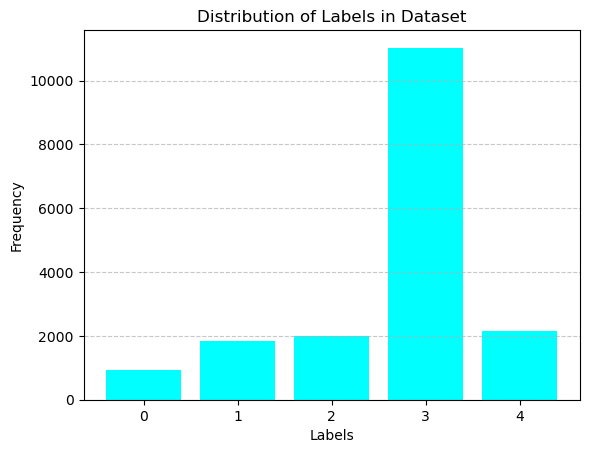

In [4]:
df = pd.read_csv(csv_path)
class_distribution = df['label'].value_counts().sort_index()
plt.bar(class_distribution.index, class_distribution.values, color='aqua')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in Dataset')
plt.xticks(class_distribution.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Organizing dataset

- Categorizing each class into folders.


In [9]:
destination_dir = r'D:\Datasets\CropDiseaseClassificationOriginal\organizedData'

class_names = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}

for class_label, class_name in class_names.items():
    class_path = os.path.join(destination_dir, class_name)
    if not os.path.exists(class_path):
        os.makedirs(class_path)

for index, row in df.iterrows():
    file_name = row['image_id']
    class_label = row['label']
    source_file = os.path.join(image_dir, file_name)
    destination_path = os.path.join(destination_dir, class_names[class_label], file_name)

    if os.path.isfile(source_file):  
        shutil.copy(source_file, destination_path)

print("Images have been copied and organized according to their classes.")


Images have been copied and organized according to their classes.


# Splitting of Data

- As images for some classes were already low, it was best to keep 80% for training

In [10]:
def split_data(source_directory, destination_directory, train_size=0.8):
    classes = os.listdir(source_directory)
    train_directory = os.path.join(destination_directory, 'train')
    test_directory = os.path.join(destination_directory, 'test')
    
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)
    
    for class_name in classes:
        class_dir = os.path.join(source_directory, class_name)
        train_class_dir = os.path.join(train_directory, class_name)
        test_class_dir = os.path.join(test_directory, class_name)
        
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        all_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        
        train_files, test_files = train_test_split(all_files, train_size=train_size, random_state=42)
        
        for file in train_files:
            shutil.move(os.path.join(class_dir, file), os.path.join(train_class_dir, file))
        for file in test_files:
            shutil.move(os.path.join(class_dir, file), os.path.join(test_class_dir, file))

source_dir = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\organizedData'
dest_dir = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\'

split_data(source_dir, dest_dir)


# Augmenting the images

Requirement to run this code properly: Undersample class 4 to 3000 images and copy paste the organizedData to another directory where you want the data augmented


In [3]:
def random_rotation(image):
    angle = np.random.choice([90, 180, 270])
    return rotate(image, angle, axes=(0, 1), reshape=False, mode='reflect')

    
def load_images(folder_path, target_size=None):
    """ Load all images from a folder and resize them if target_size is provided. """
    images = []
    filenames = os.listdir(folder_path)
    for filename in filenames:
        img_path = os.path.join(folder_path, filename)
        with Image.open(img_path) as img:
            if target_size:
                img = img.resize(target_size, Image.Resampling.LANCZOS)
            images.append(np.array(img, dtype=np.float32))
    return images, filenames

def augment_images(data_gen, images, labels, batch_size, save_path, prefix, target_count):
    """ Augment images and save them to a directory, stopping when the target count is reached. """
    generator = data_gen.flow(images, labels, batch_size=batch_size, save_to_dir=save_path, save_prefix=prefix, save_format='jpeg')
    current_count = len(images)  
    for i, (img_batch, label_batch) in enumerate(generator):
        current_count += len(img_batch)  
        if current_count >= target_count:  
            print(f"Target reached with batch {i}. Total count now {current_count}.")
            break
        print(f"Batch {i} saved, {len(img_batch)} images")
        gc.collect()  

def generate_and_save_augmented_images(root_folder, save_folder, target_size=None, target_count=3000):
    data_gen = ImageDataGenerator(
        preprocessing_function=random_rotation,  
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.4,
        shear_range=20.0,
        fill_mode='reflect'
    )
    label_encoder = LabelEncoder()

    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        save_path = os.path.join(save_folder, folder_name)
        if not os.path.exists(save_path):
            os.makedirs(save_path) 
        
        images, filenames = load_images(folder_path, target_size=target_size)
        labels = [folder_name] * len(images)
        images_array = np.array(images)
        labels_array = label_encoder.fit_transform(labels)
        labels_array = to_categorical(labels_array)

        current_count = len(images)
        needed = target_count - current_count
        print(f"Processing {folder_name}, initial count: {current_count}, target: {target_count}, needed: {needed}")
        
        if needed > 0:
            batch_size = min(100, needed)
            augment_images(data_gen, images_array, labels_array, batch_size, save_path, 'aug', target_count)

root_folder = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\train'
save_folder = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\AugmentedCropDiseasev2'

generate_and_save_augmented_images(root_folder, save_folder, target_size=(224, 224), target_count=3000)


Processing Cassava Bacterial Blight (CBB), initial count: 700, target: 3000, needed: 2300
Batch 0 saved, 100 images
Batch 1 saved, 100 images
Batch 2 saved, 100 images
Batch 3 saved, 100 images
Batch 4 saved, 100 images
Batch 5 saved, 100 images
Batch 6 saved, 100 images
Batch 7 saved, 100 images
Batch 8 saved, 100 images
Batch 9 saved, 100 images
Batch 10 saved, 100 images
Batch 11 saved, 100 images
Batch 12 saved, 100 images
Batch 13 saved, 100 images
Batch 14 saved, 100 images
Batch 15 saved, 100 images
Batch 16 saved, 100 images
Batch 17 saved, 100 images
Batch 18 saved, 100 images
Batch 19 saved, 100 images
Batch 20 saved, 100 images
Batch 21 saved, 100 images
Target reached with batch 22. Total count now 3000.
Processing Cassava Brown Streak Disease (CBSD), initial count: 1400, target: 3000, needed: 1600
Batch 0 saved, 100 images
Batch 1 saved, 100 images
Batch 2 saved, 100 images
Batch 3 saved, 100 images
Batch 4 saved, 100 images
Batch 5 saved, 100 images
Batch 6 saved, 100 ima

# Labelling with csv

In [7]:
import os
import csv

def create_csv(base_path,output_csv_file):
    with open(output_csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Image Name", "Label"])  
    
        for folder in os.listdir(base_path):
            folder_path = os.path.join(base_path, folder)
            
            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                        writer.writerow([filename, folder])
                    else:
                        print(filename,folder,"CHECKING!")

train_path = "D:\\Datasets\\CropDiseaseClassificationOriginal\\AugmentedCropDiseasev2"
train_csv = "D:\\Datasets\\CropDiseaseClassificationOriginal\\AugmentedCropDiseasev2\\image_labels.csv"
test_path = "D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\test"
test_csv = "D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\test\\image_labels.csv"

create_csv(train_path,train_csv)
create_csv(test_path,test_csv)


# Setting up model

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])

In [27]:
class CustomConvNet(nn.Module):
    def __init__(self):
        super(CustomConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 5)#last layer output classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 16 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [28]:
model = CustomConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [6]:
dataset_path = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\AugmentedCropDiseasev2' 
testing_path = 'D:\\Datasets\\CropDiseaseClassificationOriginal\\split_crop_disease\\test' 
dataset = ImageFolder(root=dataset_path, transform=transform)
test_dataset = ImageFolder(root=testing_path, transform=transform)

In [7]:
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = 1

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [8]:
batch_size = 32
num_workers = 4
pin_memory = True

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [34]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    print(f'Epoch {epoch+1}: Train Loss: {total_loss / len(train_loader.dataset):.4f}')

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Loss: {val_loss / len(val_loader.dataset):.4f}, Accuracy: {100 * correct / total:.2f}%')


Epoch 1: Train Loss: 1.5969
Validation Loss: 1.5823, Accuracy: 26.23%
Epoch 2: Train Loss: 1.5609
Validation Loss: 1.5383, Accuracy: 29.47%
Epoch 3: Train Loss: 1.5121
Validation Loss: 1.4747, Accuracy: 32.20%
Epoch 4: Train Loss: 1.4363
Validation Loss: 1.4035, Accuracy: 37.30%
Epoch 5: Train Loss: 1.3829
Validation Loss: 1.3600, Accuracy: 40.00%
Epoch 6: Train Loss: 1.3276
Validation Loss: 1.3360, Accuracy: 41.43%
Epoch 7: Train Loss: 1.2623
Validation Loss: 1.3113, Accuracy: 43.30%
Epoch 8: Train Loss: 1.1964
Validation Loss: 1.2827, Accuracy: 45.20%
Epoch 9: Train Loss: 1.1392
Validation Loss: 1.2925, Accuracy: 45.67%
Epoch 10: Train Loss: 1.0177
Validation Loss: 1.3418, Accuracy: 45.57%
Epoch 11: Train Loss: 0.8964
Validation Loss: 1.4431, Accuracy: 43.30%
Epoch 12: Train Loss: 0.7000
Validation Loss: 1.6161, Accuracy: 43.33%
Epoch 13: Train Loss: 0.5154
Validation Loss: 2.0629, Accuracy: 40.43%
Epoch 14: Train Loss: 0.3092
Validation Loss: 2.3355, Accuracy: 39.63%
Epoch 15: Train

In [35]:
from sklearn.metrics import classification_report

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

labels, preds = get_predictions(model, test_loader)
print(classification_report(labels, preds, target_names=['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)','Cassava Green Mottle (CGM)','Cassava Mosaic Disease (CMD)','Healthy']))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.15      0.28      0.19       221
Cassava Brown Streak Disease (CBSD)       0.13      0.33      0.19       431
         Cassava Green Mottle (CGM)       0.08      0.29      0.13       493
       Cassava Mosaic Disease (CMD)       0.93      0.59      0.72      8027
                            Healthy       0.11      0.30      0.16       466

                           accuracy                           0.54      9638
                          macro avg       0.28      0.36      0.28      9638
                       weighted avg       0.80      0.54      0.63      9638



In [37]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    print(f'Epoch {epoch+1}: Train Loss: {total_loss / len(train_loader.dataset):.4f}')

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Loss: {val_loss / len(val_loader.dataset):.4f}, Accuracy: {100 * correct / total:.2f}%')


C:\Users\abdul\miniconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss: 0.9741
Validation Loss: 0.7705, Accuracy: 71.10%
Epoch 2: Train Loss: 0.5842
Validation Loss: 0.7431, Accuracy: 72.70%
Epoch 3: Train Loss: 0.3074
Validation Loss: 0.8253, Accuracy: 72.77%
Epoch 4: Train Loss: 0.1258
Validation Loss: 0.9732, Accuracy: 72.60%
Epoch 5: Train Loss: 0.0652
Validation Loss: 0.9940, Accuracy: 74.30%
Epoch 6: Train Loss: 0.0515
Validation Loss: 1.0837, Accuracy: 73.23%
Epoch 7: Train Loss: 0.0386
Validation Loss: 1.0902, Accuracy: 74.13%
Epoch 8: Train Loss: 0.0469
Validation Loss: 1.1409, Accuracy: 73.73%
Epoch 9: Train Loss: 0.0421
Validation Loss: 1.1345, Accuracy: 74.03%
Epoch 10: Train Loss: 0.0295
Validation Loss: 1.2608, Accuracy: 72.83%
Epoch 11: Train Loss: 0.0342
Validation Loss: 1.1973, Accuracy: 74.17%
Epoch 12: Train Loss: 0.0369
Validation Loss: 1.2178, Accuracy: 73.17%
Epoch 13: Train Loss: 0.0428
Validation Loss: 1.1485, Accuracy: 74.23%
Epoch 14: Train Loss: 0.0321
Validation Loss: 1.1878, Accuracy: 74.13%
Epoch 15: Train

In [38]:
labels, preds = get_predictions(model, test_loader)
print(classification_report(labels, preds, target_names=['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)','Cassava Green Mottle (CGM)','Cassava Mosaic Disease (CMD)','Healthy']))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.46      0.58      0.52       221
Cassava Brown Streak Disease (CBSD)       0.48      0.72      0.58       431
         Cassava Green Mottle (CGM)       0.49      0.66      0.56       493
       Cassava Mosaic Disease (CMD)       0.98      0.89      0.93      8027
                            Healthy       0.39      0.69      0.50       466

                           accuracy                           0.85      9638
                          macro avg       0.56      0.71      0.62      9638
                       weighted avg       0.89      0.85      0.87      9638



In [6]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)#Hyperparameters changed with no validation set
num_epochs = 25
for epoch in range(num_epochs): 
    model.train()  
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step()  
        total_loss += loss.item() * images.size(0) 

    print(f'Epoch {epoch+1}: Train Loss: {total_loss / len(train_loader.dataset):.4f}')



Epoch 1: Train Loss: 1.5078
Epoch 2: Train Loss: 1.4088
Epoch 3: Train Loss: 1.3658
Epoch 4: Train Loss: 1.3086
Epoch 5: Train Loss: 1.2691
Epoch 6: Train Loss: 1.2184
Epoch 7: Train Loss: 1.1655
Epoch 8: Train Loss: 1.1092
Epoch 9: Train Loss: 1.0647
Epoch 10: Train Loss: 1.0151
Epoch 11: Train Loss: 0.9570
Epoch 12: Train Loss: 0.8718
Epoch 13: Train Loss: 0.7700
Epoch 14: Train Loss: 0.6517
Epoch 15: Train Loss: 0.5346
Epoch 16: Train Loss: 0.4250
Epoch 17: Train Loss: 0.3199
Epoch 18: Train Loss: 0.2813
Epoch 19: Train Loss: 0.2245
Epoch 20: Train Loss: 0.2035
Epoch 21: Train Loss: 0.1759
Epoch 22: Train Loss: 0.2014
Epoch 23: Train Loss: 0.1585
Epoch 24: Train Loss: 0.1386
Epoch 25: Train Loss: 0.1430


In [7]:
labels, preds = get_predictions(model, test_loader)
print(classification_report(labels, preds, target_names=['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)','Cassava Green Mottle (CGM)','Cassava Mosaic Disease (CMD)','Healthy']))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.20      0.33      0.25       221
Cassava Brown Streak Disease (CBSD)       0.16      0.56      0.25       431
         Cassava Green Mottle (CGM)       0.13      0.34      0.19       493
       Cassava Mosaic Disease (CMD)       0.96      0.66      0.78      8027
                            Healthy       0.16      0.35      0.22       466

                           accuracy                           0.62      9638
                          macro avg       0.32      0.45      0.34      9638
                       weighted avg       0.83      0.62      0.69      9638



In [11]:
model = models.resnext50_32x4d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 25
for epoch in range(num_epochs): 
    model.train()  
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, labels)  #
        loss.backward()  
        optimizer.step()  
        total_loss += loss.item() * images.size(0)  #

    # Print the average loss for the epoch
    print(f'Epoch {epoch+1}: Train Loss: {total_loss / len(train_loader.dataset):.4f}')



C:\Users\abdul\miniconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\abdul\miniconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to C:\Users\abdul/.cache\torch\hub\checkpoints\resnext50_32x4d-7cdf4587.pth
100%|█████████████████████████████████████████████████████████████████████████████| 95.8M/95.8M [01:00<00:00, 1.65MB/s]


Epoch 1: Train Loss: 0.7887
Epoch 2: Train Loss: 0.4157
Epoch 3: Train Loss: 0.2025
Epoch 4: Train Loss: 0.1370
Epoch 5: Train Loss: 0.1058
Epoch 6: Train Loss: 0.0944
Epoch 7: Train Loss: 0.0832
Epoch 8: Train Loss: 0.0706
Epoch 9: Train Loss: 0.0706
Epoch 10: Train Loss: 0.0613
Epoch 11: Train Loss: 0.0530
Epoch 12: Train Loss: 0.0786
Epoch 13: Train Loss: 0.0485
Epoch 14: Train Loss: 0.0448
Epoch 15: Train Loss: 0.0552
Epoch 16: Train Loss: 0.0453
Epoch 17: Train Loss: 0.0390
Epoch 18: Train Loss: 0.0403
Epoch 19: Train Loss: 0.0538
Epoch 20: Train Loss: 0.0431
Epoch 21: Train Loss: 0.0495
Epoch 22: Train Loss: 0.0349
Epoch 23: Train Loss: 0.0224
Epoch 24: Train Loss: 0.0354
Epoch 25: Train Loss: 0.0482


In [12]:
labels, preds = get_predictions(model, test_loader)
print(classification_report(labels, preds, target_names=['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)','Cassava Green Mottle (CGM)','Cassava Mosaic Disease (CMD)','Healthy']))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.42      0.62      0.50       221
Cassava Brown Streak Disease (CBSD)       0.44      0.75      0.56       431
         Cassava Green Mottle (CGM)       0.50      0.64      0.56       493
       Cassava Mosaic Disease (CMD)       0.98      0.90      0.94      8027
                            Healthy       0.49      0.63      0.55       466

                           accuracy                           0.86      9638
                          macro avg       0.57      0.71      0.62      9638
                       weighted avg       0.90      0.86      0.87      9638



In [9]:
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 25
for epoch in range(num_epochs): 
    model.train()  
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, labels)  #
        loss.backward()  
        optimizer.step()  
        total_loss += loss.item() * images.size(0)  #

    # Print the average loss for the epoch
    print(f'Epoch {epoch+1}: Train Loss: {total_loss / len(train_loader.dataset):.4f}')



C:\Users\abdul\miniconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\abdul\miniconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss: 0.8266
Epoch 2: Train Loss: 0.5086
Epoch 3: Train Loss: 0.3035
Epoch 4: Train Loss: 0.1788
Epoch 5: Train Loss: 0.1288
Epoch 6: Train Loss: 0.1159
Epoch 7: Train Loss: 0.0941
Epoch 8: Train Loss: 0.0805
Epoch 9: Train Loss: 0.0727
Epoch 10: Train Loss: 0.0704
Epoch 11: Train Loss: 0.0715
Epoch 12: Train Loss: 0.0694
Epoch 13: Train Loss: 0.0464
Epoch 14: Train Loss: 0.0600
Epoch 15: Train Loss: 0.0553
Epoch 16: Train Loss: 0.0548
Epoch 17: Train Loss: 0.0389
Epoch 18: Train Loss: 0.0535
Epoch 19: Train Loss: 0.0489
Epoch 20: Train Loss: 0.0449
Epoch 21: Train Loss: 0.0449
Epoch 22: Train Loss: 0.0370
Epoch 23: Train Loss: 0.0372
Epoch 24: Train Loss: 0.0483
Epoch 25: Train Loss: 0.0305


In [10]:
labels, preds = get_predictions(model, test_loader)
print(classification_report(labels, preds, target_names=['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)','Cassava Green Mottle (CGM)','Cassava Mosaic Disease (CMD)','Healthy']))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.45      0.58      0.50       221
Cassava Brown Streak Disease (CBSD)       0.48      0.78      0.59       431
         Cassava Green Mottle (CGM)       0.39      0.71      0.50       493
       Cassava Mosaic Disease (CMD)       0.99      0.82      0.90      8027
                            Healthy       0.31      0.70      0.43       466

                           accuracy                           0.80      9638
                          macro avg       0.52      0.72      0.58      9638
                       weighted avg       0.89      0.80      0.83      9638



In [12]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 25
for epoch in range(num_epochs): 
    model.train()  
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step()  
        total_loss += loss.item() * images.size(0) 
        l_loss / len(train_loader.dataset):.4f}')



Epoch 1: Train Loss: 0.9330
Epoch 2: Train Loss: 0.5645
Epoch 3: Train Loss: 0.2909
Epoch 4: Train Loss: 0.1311
Epoch 5: Train Loss: 0.0850
Epoch 6: Train Loss: 0.0579
Epoch 7: Train Loss: 0.0502
Epoch 8: Train Loss: 0.0559
Epoch 9: Train Loss: 0.0600
Epoch 10: Train Loss: 0.0553
Epoch 11: Train Loss: 0.0441
Epoch 12: Train Loss: 0.0361
Epoch 13: Train Loss: 0.0284
Epoch 14: Train Loss: 0.0234
Epoch 15: Train Loss: 0.0173
Epoch 16: Train Loss: 0.0177
Epoch 17: Train Loss: 0.0146
Epoch 18: Train Loss: 0.0126
Epoch 19: Train Loss: 0.0125
Epoch 20: Train Loss: 0.0115
Epoch 21: Train Loss: 0.0093
Epoch 22: Train Loss: 0.0072
Epoch 23: Train Loss: 0.0064
Epoch 24: Train Loss: 0.0097
Epoch 25: Train Loss: 0.0101


In [13]:
labels, preds = get_predictions(model, test_loader)
print(classification_report(labels, preds, target_names=['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)','Cassava Green Mottle (CGM)','Cassava Mosaic Disease (CMD)','Healthy']))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.39      0.58      0.46       221
Cassava Brown Streak Disease (CBSD)       0.59      0.77      0.67       431
         Cassava Green Mottle (CGM)       0.55      0.68      0.61       493
       Cassava Mosaic Disease (CMD)       0.98      0.91      0.94      8027
                            Healthy       0.43      0.67      0.53       466

                           accuracy                           0.87      9638
                          macro avg       0.59      0.72      0.64      9638
                       weighted avg       0.90      0.87      0.88      9638

